# Light Curve Modeling with MCMC

## Comments
* I model t0, per, rp, a, inc, bl, u1, u2.
* The larger the dimention ( = # of variables) the longer the time of chains.
* The chains won't converge (see autocorrelation time) because of bl, u1, u2 modeling attempt. 
* u1, u2 usually are modeled by q1 and q2

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
from IPython.display import display, Math
import corner
import collections
import emcee
import batman
%matplotlib notebook

## Necessary functions

In [14]:
def f_batman(x, t0, per, rp, a, inc, baseline, u1, u2, ecc=0.0, w=90,limb_dark ="quadratic"):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0                     #time of inferior conjunction
    params.per = per                  #orbital period
    params.rp =  rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                     #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = [u1, u2]               #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline

def log_prior(theta):
    # Priors for MCMC. 
    #Uniform/flat priors on a, rp, inc, t0
    #Gaussian on per

    t0, per, rp, a, inc, bl, u1, u2  = theta
    
    if a < priors[3] - 1. or a > priors[3] + 1.:
        return -np.inf
    
    if rp < 0. or rp > priors[2] + 0.5:
        return -np.inf
    
    # inclination should be less than 90
    if inc > 90. or inc < priors[4] - 10.:
        return -np.inf
    
    #t0 must be within priors[2] up to 0.05
    if t0 < priors[0] - 0.05 or t0 > priors[0] + 0.05:
            return -np.inf
    
    if u1 < priors[-2] - .5 or u1 > priors[-2] + .5:
        return -np.inf

    if u2 < priors[-1] - .5 or u1 > priors[-1] + .5:
        return -np.inf
    
#     if bl < priors[5] - 1e-5 or bl > priors[5] + 1e-5: 
#         return -np.inf
    
    # A Gaussian prior on the orbital period
    period_mu = priors[1]
    period_sigma = 1e-3
    period_prob = 1 / period_sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * ((per - period_mu) / (period_sigma)) ** 2)
    return np.log(period_prob)

#model = LC1(t0_0, pars) + LC1(t0_1, pars) + ....
def log_likelihood(theta, x, y, yerr):
    model = f_batman(x, *theta)
    return -0.5 * np.sum((flux - model) ** 2 / yerr**2 + np.log(2. * np.pi*(yerr**2)))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [15]:
#TESS data TOI-193
time, flux, flux_err = np.loadtxt('/home/astropc/allesfitter-master/ttvs_TOI-193/allesfit_linear_ephemerides/LTT9779b_alldata.csv', delimiter=',', skiprows=1).T

#TOI-193 parameters from LTT9779b paper
t0, per, rp, a, inc, bl, u1, u2 = 4915354.21679, 0.7920520, 0.0455, 3.877, 76.39, 0.0, 0.45, 0.45
t0_err, per_err= 0.00025, 0.0000093 

<IPython.core.display.Javascript object>


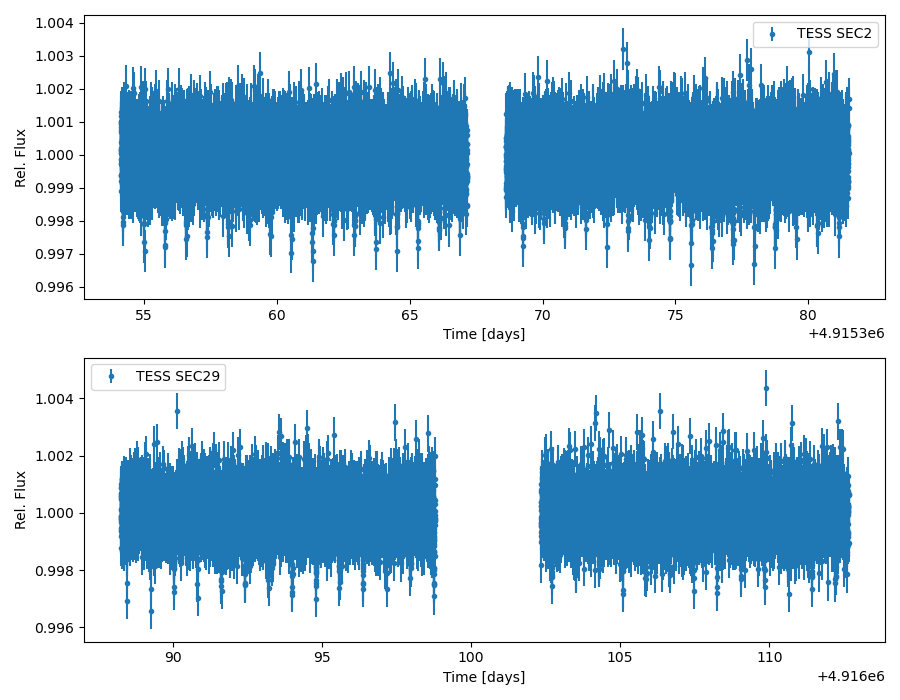

In [16]:
#plot full dataset
fig, ax = plt.subplots(2,1, figsize = (9, 7))

cond = time < (time.max() - time.min())/2 + time.min()
ax[0].errorbar(time[cond], flux[cond], flux_err[cond], fmt = '.', label = 'TESS SEC2')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Rel. Flux')
ax[0].legend()

ax[1].errorbar(time[~cond], flux[~cond], flux_err[~cond], fmt = '.', label = 'TESS SEC29')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Rel. Flux')
ax[1].legend()

plt.tight_layout()

In [ ]:
time, flux, flux_err = time[cond], flux[cond], flux_err[cond]

#MCMC parameters
labels = ['t0', 'per', 'a', 'rp', 'inc', 'bl', 'u1', 'u2']
priors = [t0, per, rp, a, inc, bl, u1, u2]
chains = 10000
ndim = len(labels)
nwalkers = ndim*10 # Number of walkers. How many? Minimum twice the amount of parameters to be fit
guess = [t0, per, rp, a, inc, bl, u1, u2] #theta to be entered as guess/starting point
order_of_mag = 1e-3#np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3])
pos = guess + order_of_mag * np.random.randn(nwalkers, ndim) #N(guess, order_of_mag**2)

#Run MCMC with Multiple Cores
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err),pool=pool)
    sampler.run_mcmc(pos, chains, progress=True)

 40%|████      | 4028/10000 [02:58<04:04, 24.40it/s]

In [ ]:
# #Get autocorrelation time. This must be checked for all data. See trace_raw figures 
# #Autocorrelation time is related to how long chains need to 'forget' where it started
# tau = sampler.get_autocorr_time()
# # thinby = int(tau.max() / 2) # thin by half the max value. See emcee docs
# print('Probably no covergence! Check tau')

In [ ]:
fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, ndim * 2))
#Depending on chain may drain RAM memmory
for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(labels[i])
    axes[i].axhline(y=guess[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
plt.tight_layout()

In [ ]:
burn_in = int(0.1*chains)
thinby = int(0.01*chains)
flat_samples = sampler.get_chain(discard=burn_in, thin=thinby, flat=True)

fit = np.array([])

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    fit = np.append(fit, [mcmc[1]])

In [ ]:
fig = corner.corner(flat_samples, labels=labels)

### Plot final model with 100 (see inds.size) thetas/samples from the posterior.

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
fig, ax = plt.subplots(1, 1)

ax.errorbar(time, flux, flux_err, fmt='.', alpha = 0.1)
for ind in inds:
    ax.plot(time, f_batman(time, *flat_samples[ind]), color='k', linestyle='solid', alpha=0.3)